In [3]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [5]:
def analytical(t):
    return torch.exp(-0.4*t)*(4.59*torch.sin(1.96*t) + 5*torch.cos(1.96*t))

# We fix variables for clarity.
T = 10
zeta, omega = 0.2, 2.0
x0, v0 = 5.0, 7.0

t = torch.linspace(0, T, 128)
solution = analytical(t)

In [6]:
from pinns.samplers import ConstantSampler, RandomRectangularSampler

constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad = True),
    torch.tensor([x0, v0])
))

domain = {'t': [0, T]}
collocation_sampler = RandomRectangularSampler(domain, 256, return_dict=False)

test_points_sampler = ConstantSampler((t.view(-1, 1), solution.view(-1, 1)))

In [7]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [8]:
ip_pts, ip_vals = test_points_sampler()
dists = ip_pts[:,0]

In [13]:
from pinns import Trainer
from pinns.models import FF
from pinns.optimizers import Adam
from pinns.metrics import l2

pinn = FF([1] + [64] + [1], activ=nn.Tanh(), biases=True)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
)

num_iters = 10000

errors = []
def save_error():
    if trainer.iter == 0 or (trainer.iter + 1) % 25 == 0:
        preds = pinn(ip_pts).detach()
        error = (preds - ip_vals).abs().flatten()
        errors.append(error)

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics=[l2],
    test_sampler=test_points_sampler,
    training_start_callbacks = [save_error],
    epoch_end_callbacks = [save_error]
    )

Model has {'total': 193, 'trainable': 193} trainable parameters.


  0%|          | 0/10000 [00:00<?, ?it/s]

It depends on particular case, whether it is good value or not.

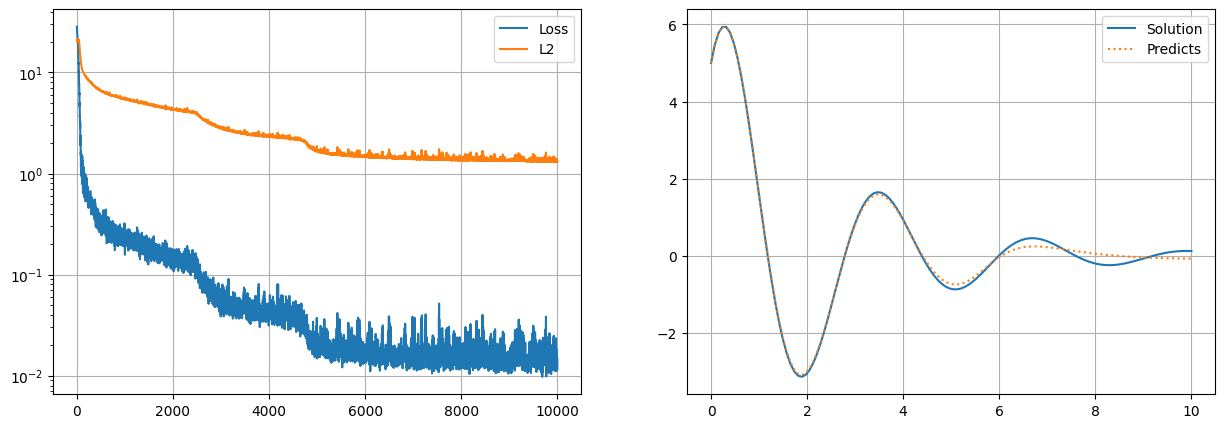

In [14]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot([ls for ls in trainer.loss_history], label='Loss')

l2_history = [er[0] for er in trainer.error_history]
# rel_l2_history = [er[1] for er in trainer.error_history]
# mse_history = [er[2] for er in trainer.error_history]
x = range(0, trainer.iter + 1, 1)

axs[0].plot(x, l2_history, label='L2')
# axs[0].plot(x, rel_l2_history, label='RelL2')
# axs[0].plot(x, mse_history, label='MSE')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(t.reshape(-1, 1))
axs[1].plot(t, solution, label='Solution')
axs[1].plot(t, preds.detach(), label='Predicts', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.show()

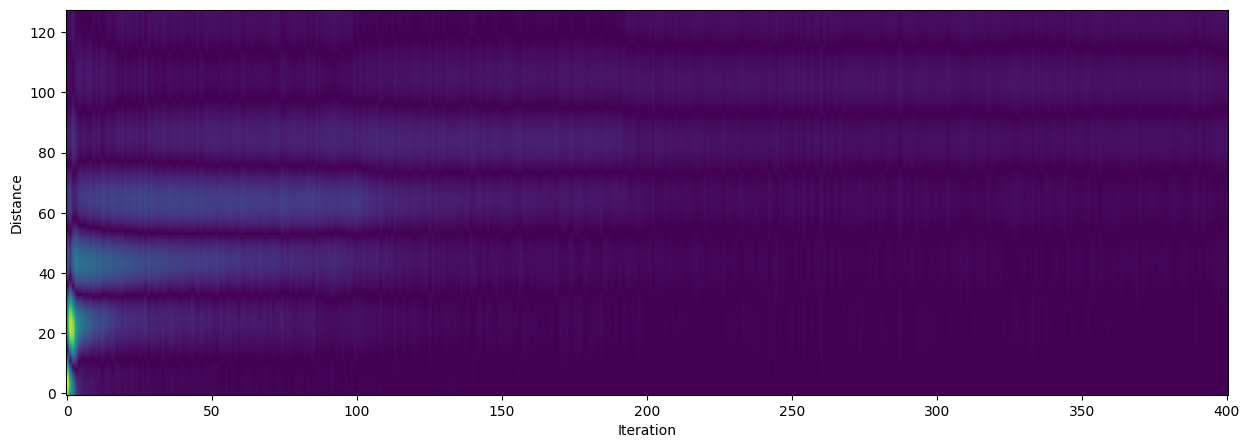

In [15]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 0].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()